In [1]:
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class cutter:
    instances = []
    
    def __init__(self, name, BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data):
        self.__class__.instances.append(self)
        self.name = name
        self.BR = BR # cutter back rake angle
        self.Vc = Vc # cutter velocity
        self.DOC_data = cutter_DOC_data_list # list of cutter depth of cut (data)
        self.IFA_data = cutter_IFA_data_list # list of cutter IFA values (data)
        self.VN = Vc / 2.1 # normalized cutter velocity
        self.UCS = UCS # rock unconfined compressive strength
        self.UCSN = UCS / 5000 # normalized rock unconfined compressive strength
        self.Dc = Dc # cutter diameter
        self.Rc = Dc/2 # cutter radius
        self.Aw = Aw # wearflat area sq-inch
        self.Fn_data = cutter_Fn_data # cutter normal force. for blunt cutter case.
        self.Fd_data = cutter_Fd_data # cutter drag force. for blunt cutter case.
        
    def Model_IFA(self, DOC):
        ''' A model for IFA calculation. it takes DOC,
        normalized cutter velocity, normalized rock 
        UCS and cutter back rake and returns the IFA.'''
        
        #comperhensive IFA model utilizing both fullbit and single cutter data for soft and hard rocks
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 46.873 + (-112.417)/((self.VN)**1 + 3)
        b = 19.506 
        c = 0.3755
        d = 0.109 + 2.753/((self.UCSN**2.227) + 1.954)'''
        
        #hard  rock IFA model utilizing both single cutter and fullbit data
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 57.15 + (-120)/((self.VN)**1 + 3)
        b = 8.35 
        c = 0.55
        d = 0 + 16.74/((self.UCSN**2.5) + 100)'''
        
        #amin thesis
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 70.66 + (-130.09)/((self.VN)**0.99 + 2.77)
        b = 0.49 + (19.62)/((self.VN)**1.15 + 40)
        c = 1.24
        d = 0.014 + 0.99/((self.UCSN**2.72) + 2.09)'''
        
        
        # GH approach 
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 70.66 + (-130.09)/((self.VN)**0.99 + 2.77)
        b = 0.88 + (29.80)/((self.VN)**1.85 + 82.5)
        c = 1.24
        d = 0 + (0.93)/((self.UCSN**2) + 1.41)'''
        
        
        #GH approach for Carthage+single cutter+RH data 80 rpm
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 32.29 + (-161.32)/((self.VN)**0.854 + 16.7)
        b = 34.56 + (-187.32)/((self.VN)**2.43 + 10.12)
        c = 0.462
        d = 0 + 18.04/((self.UCSN**2.26) + 20.68)'''
        
        
        #GH-IFA (II)
        DOCn = DOC / self.Dc # normalize DOC
        a = 18.90 + (-142.78)/((self.VN)**0.65 + 2.83)
        b = 75.56 + (150)/((self.VN)**2 + 100)
        c = 0.454
        d = 0.323 + (53.61)/((self.UCSN**2.5) + 84.86)

 
        return (a + b / ((DOCn**c) + d))-self.BR
    
    def Find_L(self):
        '''A function that search for L on cutter face.
        Applicable to blunt cutter.'''
        diff = 10
        L = 0
        while diff > 0.0001:
            L += 0.00001
            A_segment_esti = ((self.Rc)**2*math.acos((self.Rc-L)/self.Rc)\
                       -(self.Rc-L)*((self.Dc*L-(L)**2)**0.5))
            diff = abs(self.Aw_on_cutter_face-A_segment_esti)
        return L
    
    def Calculate_fitness(self):
        
        if self.Aw == 0:

            # calculate some paramters using above provided data
            self.Fn_Fd_list = [i / j for i, j in zip(self.Fn_data, self.Fd_data)] # cutter normal to drag force ratio
            self.IFA_list_DD_Model = [((math.atan(Fn_Fd)*180)/math.pi-self.BR) for Fn_Fd in self.Fn_Fd_list] # calculated IFA list
            self.IFA_list_with_Model = [self.Model_IFA(DOC) for DOC in self.DOC_data]
            self.L_list = [(DOC/math.cos(math.radians(self.BR))) for DOC in self.DOC_data] # DOC projected length on cutter face
            self.A_contact_list = [((self.Rc)**2*math.acos((self.Rc-L)/self.Rc)-(self.Rc-L)*((self.Dc*L-(L)**2)**0.5)) for L in self.L_list] # calculated cutter contact area
            self.A_F_list_without_IFA = [(A_contact*math.cos(math.radians(self.BR))) for A_contact in self.A_contact_list] 
            self.F_d_without_IFA = [A_F * self.UCS for A_F in self.A_F_list_without_IFA]
            self.A_F_list_with_IFA = [(A_contact*math.cos(math.radians(IFA+self.BR))) for IFA, A_contact in zip(self.IFA_list_with_Model, self.A_contact_list)] 
            self.F_d_with_IFA = [A_F * self.UCS for A_F in self.A_F_list_with_IFA]
            self.A_B_list_without_IFA = [(A_contact*math.sin(math.radians(self.BR))) for IFA, A_contact in zip(self.IFA_list_with_Model, self.A_contact_list)] 
            self.F_n_without_IFA = [A_B * self.UCS for A_B in self.A_B_list_without_IFA]
            self.A_B_list_with_IFA = [(A_contact*math.sin(math.radians(IFA+self.BR))) for IFA, A_contact in zip(self.IFA_list_with_Model, self.A_contact_list)] 
            self.F_n_with_IFA = [A_B * self.UCS for A_B in self.A_B_list_with_IFA]
            
        else:
                        
            self.Fn_Fd_list = [i / j for i, j in zip(self.Fn_data, self.Fd_data)] # cutter normal to drag force ratio
            self.IFA_list_DD_Model = [((math.atan(Fn_Fd)*180)/math.pi-self.BR) for Fn_Fd in self.Fn_Fd_list] # calculated IFA list
            self.IFA_list_with_Model = [self.Model_IFA(DOC) for DOC in self.DOC_data]
            self.Aw_on_cutter_face = self.Aw*math.cos(math.radians((90-self.BR)))
            self.L_list = [(DOC/math.cos(math.radians(self.BR))) for DOC in self.DOC_data] # DOC projected length on cutter face
            self.L_worn = self.Find_L() # single value
            self.Total_L = [(self.L_worn + L) for L in self.L_list] # total L, summation 
            self.A_total_segment = [((self.Rc)**2*math.acos((self.Rc-L)/self.Rc)-(self.Rc-L)*((self.Dc*L-(L)**2)**0.5)) for L in self.Total_L]
            self.A_real_contact_list = [(a-self.Aw_on_cutter_face) for a in self.A_total_segment]
            #============================================================================================
            self.A_F_list_without_IFA = [(A_contact*math.cos(math.radians(self.BR))) for A_contact in self.A_real_contact_list] 
            self.F_d_without_IFA = [A_F * self.UCS for A_F in self.A_F_list_without_IFA]
            self.A_F_list_with_IFA = [(A_contact*math.cos(math.radians(IFA+self.BR))) for IFA, A_contact in zip(self.IFA_list_with_Model, self.A_real_contact_list)] 
            self.F_d_with_IFA = [A_F * self.UCS for A_F in self.A_F_list_with_IFA]
            self.A_B_list_without_IFA = [(A_contact*math.sin(math.radians(self.BR))) for A_contact in self.A_real_contact_list] 
            self.F_n_without_IFA = [A_B * self.UCS for A_B in self.A_B_list_without_IFA]
            self.A_B_list_with_IFA = [(A_contact*math.sin(math.radians(IFA+self.BR))) for IFA, A_contact in zip(self.IFA_list_with_Model, self.A_real_contact_list)] 
            self.F_n_with_IFA = [A_B * self.UCS for A_B in self.A_B_list_with_IFA]
            #============================================================================================
            miu = 0.6 # internal friction coefficient for SWG
            self.F_n_with_IFA_miu = [Fn + self.Aw*self.UCS for Fn in self.F_n_with_IFA]
            self.F_d_with_IFA_miu = [Fd+(self.Aw*self.UCS*miu) for Fd in self.F_d_with_IFA]
            
    @classmethod
    def Plot_Fn_DOC(cls):
        
        fig = plt.figure(figsize=(15,60))
        i = 1
        for instance in cls.instances:
            if instance.Aw == 0:
                
                plt.subplot(10, 2, i)
                plt.scatter(instance.Fn_data, instance.DOC_data, label='Data')
                plt.plot(instance.F_n_without_IFA, instance.DOC_data, 'r--', label='Model')
                plt.xlabel('Fn lbf')
                plt.ylabel('DOC inch')
                #plt.xlim(0,1000)
                plt.title('Before IFA, UCS={}, Vc={}, BR={}, Dc={}, Aw={}, {}'.format(instance.UCS,instance.Vc, instance.BR, instance.Dc, instance.Aw, instance.name))
                plt.grid(True)
                plt.legend()
                plt.subplot(10, 2, i+1)
                plt.scatter(instance.Fn_data, instance.DOC_data, label='Data')
                plt.plot(instance.F_n_with_IFA, instance.DOC_data,'r--', label='Model')
                plt.xlabel('Fn lbf')
                plt.ylabel('DOC inch')
                #plt.xlim(0,1200)
                plt.title('After IFA, UCS={}, Vc={}, BR={}, Dc={}, Aw={}, {}'.format(instance.UCS,instance.Vc, instance.BR, instance.Dc, instance.Aw, instance.name))
                plt.grid(True)
                plt.legend()
                i += 2
            else:
                plt.subplot(10, 2, i)
                plt.scatter(instance.Fn_data, instance.DOC_data, label='Data')
                plt.plot(instance.F_n_without_IFA, instance.DOC_data,'r--', label='Model')
                plt.xlabel('Fn lbf')
                plt.ylabel('DOC inch')
                plt.xlim(0,1000)
                plt.title('Before IFA, UCS={}, Vc={}, BR={}, Dc={}, Aw={}, {}'.format(instance.UCS,instance.Vc, instance.BR, instance.Dc, instance.Aw, instance.name))
                plt.grid(True)
                plt.legend()
                plt.subplot(10, 2, i+1)
                plt.scatter(instance.Fn_data, instance.DOC_data, label='Data')
                plt.plot(instance.F_n_with_IFA_miu, instance.DOC_data,'r--', label='Model')
                plt.xlabel('Fn lbf')
                plt.ylabel('DOC inch')
                plt.xlim(0,1000)
                plt.title('After IFA, UCS={}, Vc={}, BR={}, Dc={}, Aw={}, {}'.format(instance.UCS,instance.Vc, instance.BR, instance.Dc, instance.Aw, instance.name))
                plt.grid(True)
                plt.legend()
                i += 2

    @classmethod
    def Plot_Fd_DOC(cls):
        
        fig = plt.figure(figsize=(15,60))
        i = 1
        for instance in cls.instances:
            if instance.Aw == 0:
                
                plt.subplot(10, 2, i)
                plt.scatter(instance.Fd_data, instance.DOC_data, label='Data')
                plt.plot(instance.F_d_without_IFA, instance.DOC_data,'r--', label='Model')
                plt.xlabel('Fd lbf')
                plt.ylabel('DOC inch')
                #plt.xlim(0,1200)
                plt.title('Before IFA, UCS={}, Vc={}, BR={}, Dc={}, Aw={}, {}'.format(instance.UCS,instance.Vc, instance.BR, instance.Dc, instance.Aw, instance.name))
                plt.grid(True)
                plt.legend()
                plt.subplot(10, 2, i+1)
                plt.scatter(instance.Fd_data, instance.DOC_data, label='Data')
                plt.plot(instance.F_d_with_IFA, instance.DOC_data,'r--', label='Model')
                plt.xlabel('Fd lbf')
                plt.ylabel('DOC inch')
                #plt.xlim(0,1200)
                plt.title('After IFA, UCS={}, Vc={}, BR={}, Dc={}, Aw={}, {}'.format(instance.UCS,instance.Vc, instance.BR, instance.Dc, instance.Aw, instance.name))
                plt.grid(True)
                plt.legend()
                plt.legend()
                i += 2
            else:
                
                plt.subplot(10, 2, i)
                plt.scatter(instance.Fd_data, instance.DOC_data, label='Data')
                plt.plot(instance.F_d_without_IFA, instance.DOC_data,'r--', label='Model')
                plt.xlabel('Fd lbf')
                plt.ylabel('DOC inch')
                plt.xlim(0,1000)
                plt.title('Before IFA, UCS={}, Vc={}, BR={}, Dc={}, Aw={}, {}'.format(instance.UCS,instance.Vc, instance.BR, instance.Dc, instance.Aw, instance.name))
                plt.grid(True)
                plt.legend()
                plt.subplot(10, 2, i+1)
                plt.scatter(instance.Fd_data, instance.DOC_data, label='Data')
                plt.plot(instance.F_d_with_IFA_miu, instance.DOC_data,'r--', label='Model')
                plt.xlabel('Fd lbf')
                plt.ylabel('DOC inch')
                plt.xlim(0,1000)
                plt.title('After IFA, UCS={}, Vc={}, BR={}, Dc={}, Aw={}, {}'.format(instance.UCS,instance.Vc, instance.BR, instance.Dc, instance.Aw, instance.name))
                plt.grid(True)
                plt.legend()
                plt.legend()
                i += 2
                
    @classmethod
    def Plot_IFA_DOC(cls):
        
        fig = plt.figure(figsize=(15,30))
        i = 1
        for instance in cls.instances:
            
            plt.subplot(5, 2, i)
            plt.scatter(instance.DOC_data, instance.IFA_list_DD_Model, label='Data')
            plt.plot(instance.DOC_data, instance.IFA_list_with_Model,'r--', label='Model')
            plt.ylabel('IFA')
            plt.xlabel('DOC')
            plt.xlim(0,0.15)
            plt.ylim(0,90)
            plt.title('UCS={}, Vc={}, BR={}, Dc={}, Aw={}, {}'.format(instance.UCS,instance.Vc, instance.BR, instance.Dc, instance.Aw, instance.name))
            plt.grid(True)
            plt.legend()
            i += 1

### Insert Data and excute program


In [3]:
### Data Cutter J, BSS, UCS = 7100 psi, Vc = 2.1 in/sec, BR = 20, Dc = 0.5"
case1_DOC_data = [0.019,0.02,0.022,0.023,0.041,0.041,0.041,0.042,0.06,0.062,0.078,0.08,0.082]
case1_IFA_data = 0
case1_Fn_data = [18.6,16.9,17.3,13.3,62.8,58.1,57.9,60.1,94.5,91.3,128,117,116]
case1_Fd_data = [23.6,21.7,21,19.4,75.6,71.7,67.5,66,110,106,154,143,139]
#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case1 = cutter('Cutter J, BSS',20, 2.1, 7100, 0.5, 0, case1_DOC_data, case1_IFA_data, case1_Fn_data, case1_Fd_data)
case1.Calculate_fitness()

### Data Cutter K, BSS, UCS = 7100 psi, Vc = 2.1 inch/sec, BR = 20, Dc = 0.74"
case2_DOC_data = [0.021,0.023,0.023,0.02,0.022,0.023,0.021,0.041,0.042,0.042,0.042,0.041,0.041,0.041,0.08,0.08,0.08,0.08,0.08]
case2_IFA_data = 0
case2_Fn_data = [18,17,16.7,16.9,19.6,17.7,19.8,55.5,51.8,53.5,48.2,53.5,49.2,52.1,109,102,109,97.5,103]
case2_Fd_data = [24.3,26.1,19.2,23.5,23.1,23.7,24,72.5,70.5,69,64.5,68,68.3,68.2,147,142,143,138,141]
#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case2 = cutter('Cutter K, BSS',20, 2.1, 7100, 0.75, 0, case2_DOC_data, case2_IFA_data, case2_Fn_data, case2_Fd_data)
case2.Calculate_fitness()

### Data Cutter J, SWG, UCS = 21500 psi, vc = 2.1 in/sec, BR = 20, Dc = 0.5"
case3_DOC_data = [0.013,0.015,0.016,0.017,0.018,0.02,0.037,0.039,0.039,0.039,0.061,0.062]
case3_IFA_data = 0
case3_Fn_data = [23.9,25.3,30.4,31.7,29.2,38,136,131,136,137,229,256]
case3_Fd_data = [16.9,16.8,17,26.3,18.8,28.9,118,118,120,121,217,227]
#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case3 = cutter('Cutter J, SWG',20, 2.1, 21500, 0.5, 0, case3_DOC_data, case3_IFA_data, case3_Fn_data, case3_Fd_data)
case3.Calculate_fitness()

### Data TX Granite, UCS = 19400 psi, Vc = 177 in/sec, BR = 20 , Dc = 0.5"
case4_DOC_data = [0.01968505,0.0393701,0.0787402,0.1181103]
case4_IFA_data = 0
case4_Fn_data = [84.15,210.375,442.8,576.9]
case4_Fd_data = [12.15,47.925,124.2,192.825]
#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case4 = cutter('TX Granite',20, 177, 19400, 0.5, 0, case4_DOC_data, case4_IFA_data, case4_Fn_data, case4_Fd_data)
case4.Calculate_fitness()

### Data TX Granite, UCS = 19400 psi, Vc = 177 in/sec, BR = 5 , Dc = 0.5"
case5_DOC_data = [0.01968505,0.0393701,0.0787402,0.1181103]
case5_IFA_data = 0
case5_Fn_data = [116.775,144.675,411.75,532.125]
case5_Fd_data = [17.55,31.275,141.075,213.3]
#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case5 = cutter('TX Granite',5, 177, 19400, 0.5, 0, case5_DOC_data, case5_IFA_data, case5_Fn_data, case5_Fd_data)
case5.Calculate_fitness()

### Data TX Granite , UCS = 19400 psi, Vc = 177 in/sec, BR = 10 , Dc = 0.5"
case6_DOC_data = [0.01968505,0.0393701,0.0787402]
case6_IFA_data = 0
case6_Fn_data = [82.8,207.9,341.325]
case6_Fd_data = [14.175,50.625,108]
#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case6 = cutter('TX Granite',10, 177, 19400, 0.5, 0, case6_DOC_data, case6_IFA_data, case6_Fn_data, case6_Fd_data)
case6.Calculate_fitness()

### Data TX Granite, UCS = 19400 psi, Vc = 177 in/sec, BR = 15 , Dc = 0.5"
case7_DOC_data = [0.01968505,0.0393701,0.0787402,0.1181103]
case7_IFA_data = 0
case7_Fn_data = [73.35,197.55,363.825,559.575]
case7_Fd_data = [9,48.15,112.275,187.875]
#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case7 = cutter('TX Granite',15, 177, 19400, 0.5, 0, case7_DOC_data, case7_IFA_data, case7_Fn_data, case7_Fd_data)
case7.Calculate_fitness()

### Data TX Granite, UCS = 21500 psi, Vc = 177 in/sec, BR = 25 , Dc = 0.5"
case8_DOC_data = [0.01968505,0.0393701,0.0787402,0.1181103]
case8_IFA_data = 0
case8_Fn_data = [56.7,247.725,528.3,797.175]
case8_Fd_data = [1.125,51.3,142.2,249.525]
#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case8 = cutter('TX Granite',25, 177, 19400, 0.5, 0, case8_DOC_data, case8_IFA_data, case8_Fn_data, case8_Fd_data)
case8.Calculate_fitness()

### Data TX Granite, UCS = 21500 psi, Vc = 177 in/sec, BR = 30 , Dc = 0.5"
case9_DOC_data = [0.01968505,0.0393701,0.0787402,0.1181103]
case9_IFA_data = 0
case9_Fn_data = [81.225,234.9,486.45,658.125]
case9_Fd_data = [11.025,53.325,142.875,222.75]
#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case9 = cutter('TX Granite',30, 177, 19400, 0.5, 0, case9_DOC_data, case9_IFA_data, case9_Fn_data, case9_Fd_data)
case9.Calculate_fitness()

### Data Cutter D, SWG, UCS = 21500 psi, Vc = 2.1 in/sec, BR = 20 , Dc = 0.75" Blunt Aw = 0.02 in2
case10_DOC_data = [0.023,0.023,0.023,0.023,0.024,0.024,0.024,0.024,0.039,0.04,0.04,0.04,0.041,0.041,0.041,0.042,0.042,0.042,0.042,0.042,0.042,0.042,0.079,0.079,0.079,0.079,0.08]
case10_IFA_data = 0
case10_Fn_data = [545,568,599,590,610,617,640,619,657,689,699,756,669,676,698,770,770,739,763,741,774,760,855,865,926,918,875]
case10_Fd_data = [360,387,392,396,401,412,418,416,461,475,476,517,466,473,481,511,540,518,526,504,522,519,694,694,722,750,710]
#'(BR, Vc, UCS, Dc, Aw, cutter_DOC_data_list, cutter_IFA_data_list, cutter_Fn_data, cutter_Fd_data)'
case10 = cutter('Cutter D, SWG',20, 2.1, 21500, 0.75, 0.02, case10_DOC_data, case10_IFA_data, case10_Fn_data, case10_Fd_data)
case10.Calculate_fitness()

### Plot all instances in class

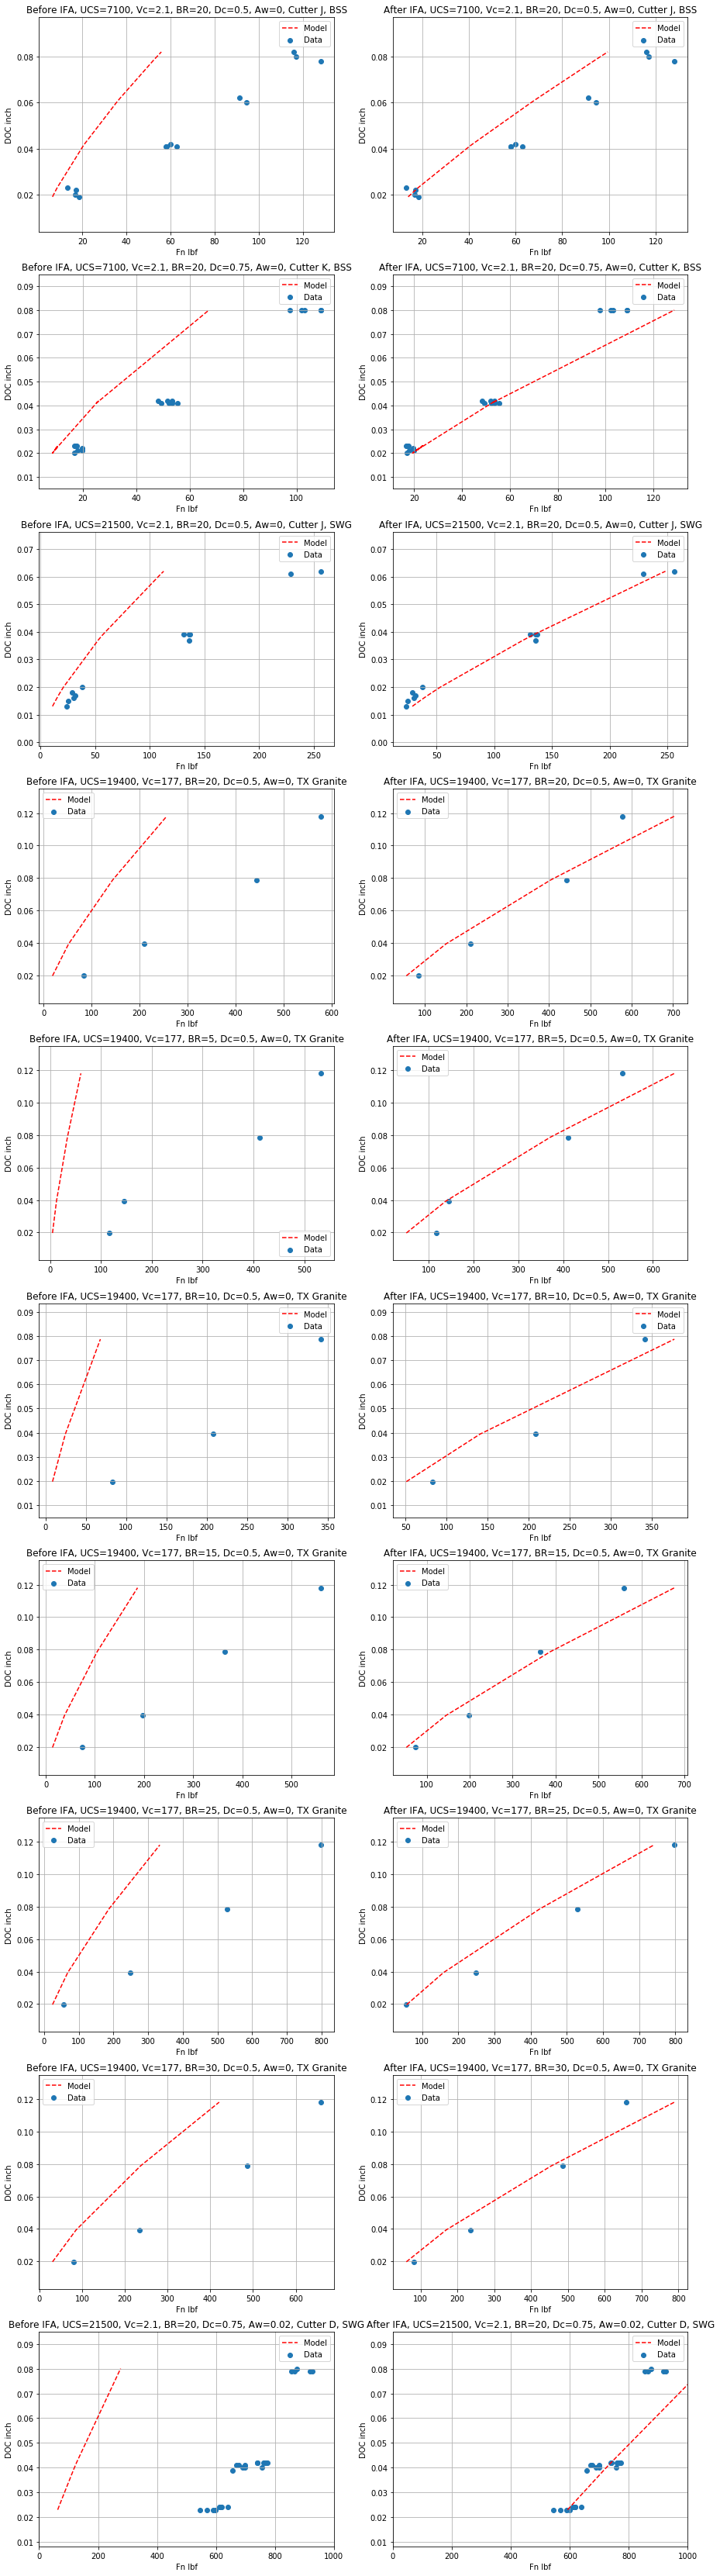

In [4]:
cutter.Plot_Fn_DOC()

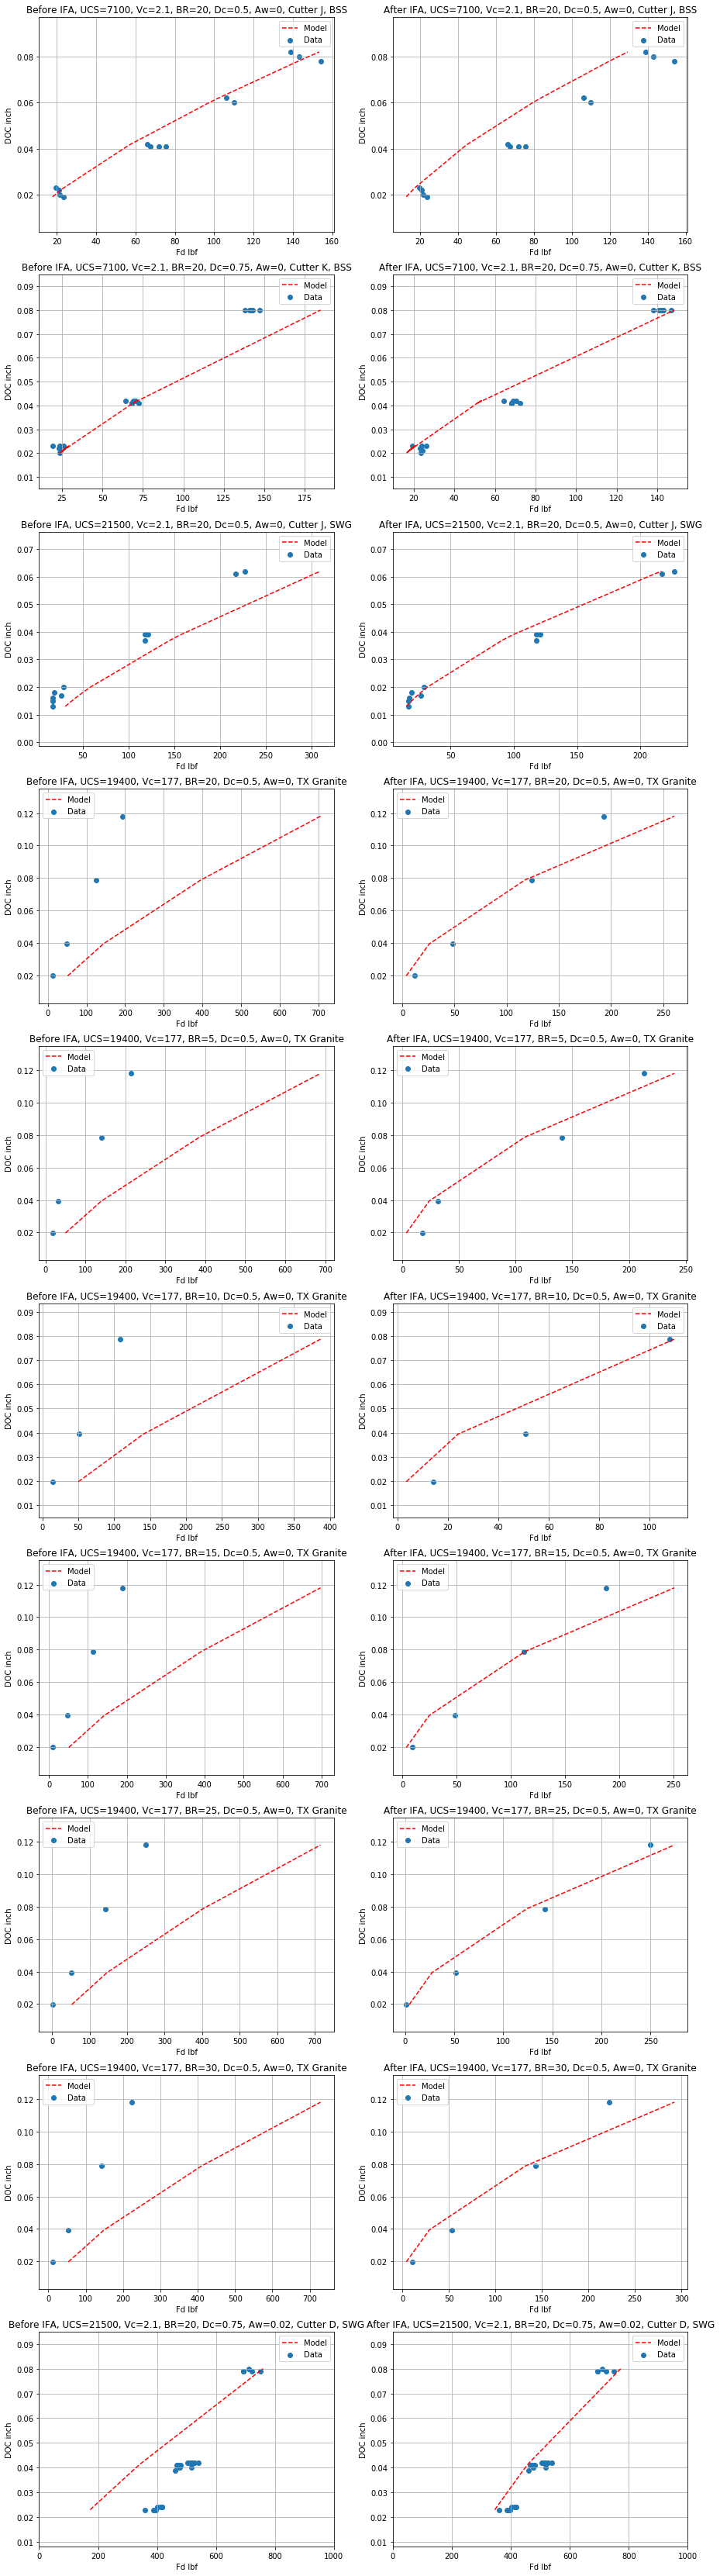

In [5]:
cutter.Plot_Fd_DOC()

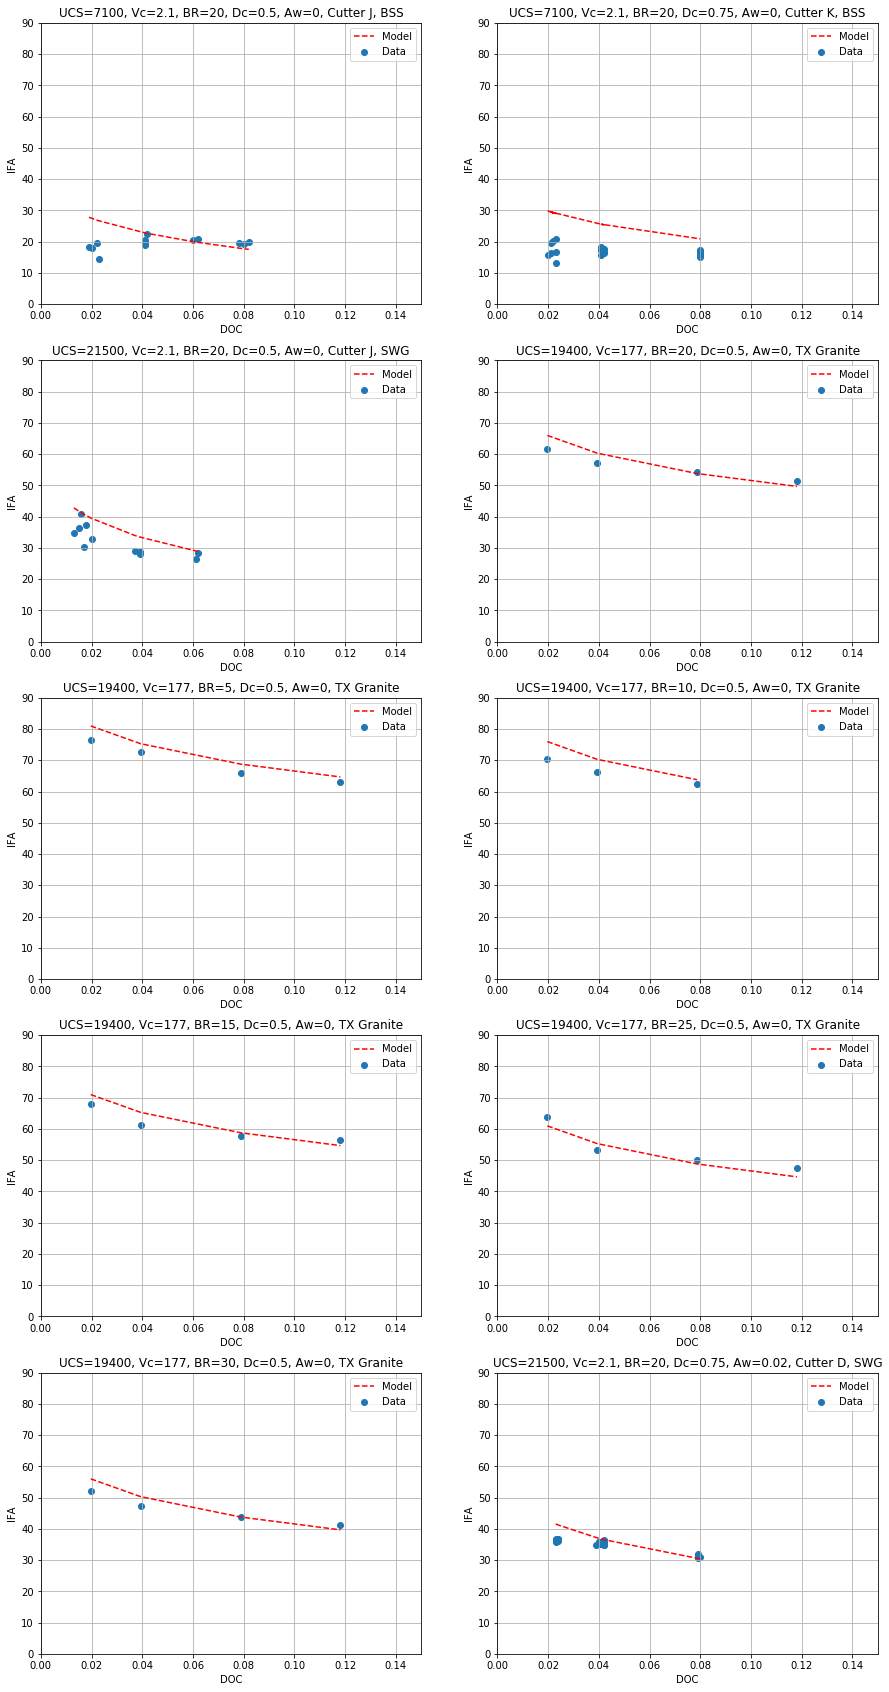

In [6]:
cutter.Plot_IFA_DOC()